### *This file allows to initialize a STG spiking neuron as well as neuromodulating them in a robust way with a controller*

# **Useful packages and functions**

In [1]:
using Plots, Plots.PlotMeasures, LaTeXStrings, Random, Dierckx, DelimitedFiles, ProgressMeter
include("network_STG_kinetics.jl") # Loading of STG kinetics of gating variables
include("network_STG_models.jl") # Loading of STG model
include("network_STG_utils.jl") # Loading of some utils functions
include("network_STG_gs_derivatives.jl") # Loading of X_inf derivatives
include("network_STG_DIC.jl") # Loading of the DIC and compensation algorithm
include("network_STG_neuromodulation.jl"); # Loading of the neuromodulation cells functions

# **Global variables**

In [2]:
# Definition of simulation time (in ms)
const Tfinal = 150000
const dt = 0.0005
const tsim = 0 : dt : Tfinal
const dtplot = 0.2
const tt = 0 : dtplot : Tfinal
const dtratio = Int(dtplot/dt)
const Tdt = Int(Tfinal/dt)
const tt_index = 1 : dtratio : Tdt+1

# Definition of reversal potential values (in mV) and membrane capacitance
const VNa   = 50. # Sodium reversal potential
const VK    = -80. # Potassium reversal potential
const VCa   = 80. # Calcium reversal potential
const VH    = -20. # Reversal potential for the H-current (permeable to both sodium and potassium ions)
const Vleak = -50. # Reversal potential of leak channels
const Vsyn = -75. # Reversal potential of synaptic channels
const C     = 1. # Membrane capacitance

# Definition of voltage range for the DICs
const Vmin = -60 
const Vmax = 0
const V    = range(Vmin, stop=Vmax, step=0.01)

# Definition of the number of cells in the random set
const ncells = 5

# Modifying backend GR attributes
gr(guidefontsize=18, legendfontsize=12, margin=5Plots.mm, grid=false)
myApple = RGBA(187/255, 206/255, 131/255, 1)
mySalmon = RGBA(243/255, 124/255, 130/255)
myYellow = RGBA(228/255, 205/255, 121/255, 1)
myBlue = RGBA(131/255, 174/255, 218/255, 1)
myDarkBlue = RGBA(114/255, 119/255, 217/255, 1)
myOrange = RGBA(241/255, 175/255, 113/255, 1)
myPink = RGBA(243/255, 124/255, 130/255, 1)
myPurple = RGBA(169/255, 90/255, 179/255, 1)
myGreen = RGBA(132/255, 195/255, 168/255, 1)
myRed = RGBA(158/255, 3/255, 8/255, 1)
default(fmt = :png)

# Moving average function
moving_average(vs, n, padding) = [sum(vs[i:(i+n-1)])/n for i in 1:padding:(length(vs)-(n-1))];

# **Test of simple modulated network with constant DICs**

In [3]:
# Fixing random seed
Random.seed!(544)

# Initial firing pattern
guth = 4.
Vth = -50.
tmKCavec = [2.; 2.; 2.; 20.; 20.]
(g_all_init, ICs_th_init) = degeneracy_fixDICs_neuromod(ncells, 5., guth, Vth, tmKCavec);
# create a spiking set with max variability in gCaS and gA

In [4]:
# Definition of parameters
Iappvec = 0. * ones(5)
gNavec = g_all_init[:, 1]
gCaTvec = g_all_init[:, 2]
gCaSvec = g_all_init[:, 3]
gAvec = g_all_init[:, 4]
gKCavec = g_all_init[:, 5]
gKdvec = g_all_init[:, 6]
gHvec = g_all_init[:, 7]
gleakvec = g_all_init[:, 8]

α = 5e-3 # Rate of transfer between intracellular and membrane
β = 5e-3 # Rate of degradation of intracellular proteins
Kp = 3e-4 # Proprtional gain
Ki = 5e-6 # Integral gain
Kt = β / Ki # Anti-windup gain
gsth_sim_nocrash(t) = -8.
gsth_sim_crash(t) = -8 * (t<5e4) 
gsth_sim_spike(t) = 5.
gsthvec = [gsth_sim_nocrash, gsth_sim_nocrash, gsth_sim_nocrash,
           gsth_sim_crash, gsth_sim_crash]
guth_sim(t) = 4.
guthvec = [guth_sim, guth_sim, guth_sim, guth_sim, guth_sim]
u_maxCaS = 1e7 # Maximum value of actuator
u_maxA = 1e7
Vthvec = ICs_th_init[:, 1]

# Definition of homeostatic parameters
tau_g = 100 # Conductance time constant
tau_Na = 600. * ones(5) # Integral action time constants
Ca_tgt = 125. # Calcium target

gsyn21 = 0.2*4
gsyn12 = 0.2*4
gsyn13 = 0.2*4
gsyn53 = 0.2*4
gsyn54 = 0.2*4
gsyn45 = 0.2*4
gEl23 = 0.05
gEl43 = 0.05

(Vconnect, Caconnect) = simulateSTG_network(
         Iappvec, gNavec, gCaTvec, gCaSvec, gAvec, gKCavec, gKdvec, 
         gHvec, gleakvec, tau_g, tau_Na, Ca_tgt, 
         gsyn21, gsyn12, gsyn13, gsyn53, gsyn45, gsyn54, 
         gEl23, gEl43, tmKCavec, α, β, Kp, Ki, Kt, gsthvec, 
         guthvec, Vthvec, u_maxCaS, u_maxA);

Computing ... 100%|██████████████████████████████████████| Time: 0:32:56mm


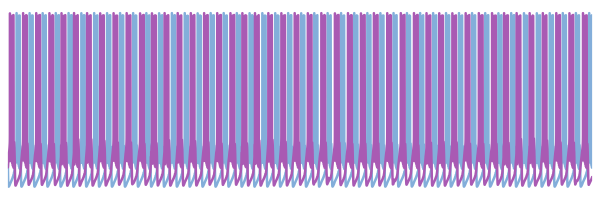

In [5]:
p = plot(tt/1e3, Vconnect[:, 1], xlims=(20, 30), xticks=false, 
         yticks=false, axis=false, linewidth=2.5, legend=false, size=(600, 200), 
         color=myBlue, margins=0px)
plot!(tt/1e3, Vconnect[:, 2], xlims=(20, 30), xticks=false, 
         yticks=false, axis=false, linewidth=2.5, legend=false, size=(600, 200), 
         color=myPurple, margins=0px)

display(p)
# savefig(p, "./figures/network_fast.pdf")

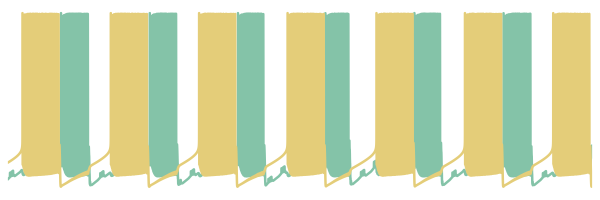

In [6]:
p = plot(tt/1e3, Vconnect[:, 4], xlims=(20, 30), xticks=false, 
         yticks=false, axis=false, linewidth=2.5, legend=false, size=(600, 200), 
         color=myGreen, margins=0px)
plot!(tt/1e3, Vconnect[:, 5], xlims=(20, 30), xticks=false, 
         yticks=false, axis=false, linewidth=2.5, legend=false, size=(600, 200), 
         color=myYellow, margins=0px)

display(p)
# savefig(p, "./figures/network_slow.pdf")

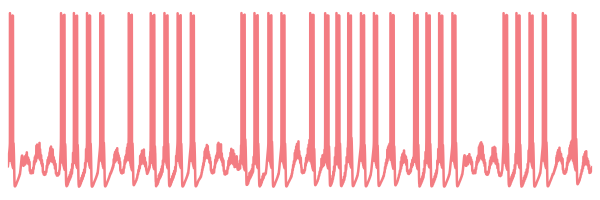

In [7]:
p = plot(tt/1e3, Vconnect[:, 3], xlims=(20, 30), xticks=false, 
         yticks=false, axis=false, linewidth=2.5, legend=false, size=(600, 200), 
         color=mySalmon, margins=0px)

display(p)
# savefig(p, "./figures/network_inner.pdf")

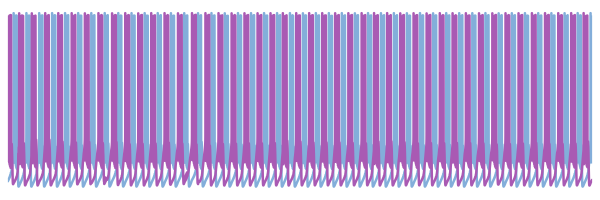

In [19]:
p = plot(tt/1e3, Vconnect[:, 1], xlims=(48, 58), xticks=false, 
         yticks=false, axis=false, linewidth=2.5, legend=false, size=(600, 200), 
         color=myBlue, margins=0px)
plot!(tt/1e3, Vconnect[:, 2], xlims=(48, 58), xticks=false, 
         yticks=false, axis=false, linewidth=2.5, legend=false, size=(600, 200), 
         color=myPurple, margins=0px)

display(p)
# savefig(p, "./figures/network_fast_NMDoff.pdf")

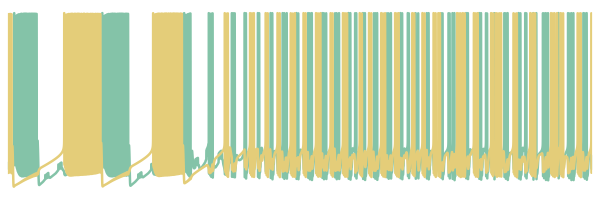

In [21]:
p = plot(tt/1e3, Vconnect[:, 4], xlims=(48, 58), xticks=false, 
         yticks=false, axis=false, linewidth=2.5, legend=false, size=(600, 200), 
         color=myGreen, margins=0px)
plot!(tt/1e3, Vconnect[:, 5], xlims=(48, 58), xticks=false, 
         yticks=false, axis=false, linewidth=2.5, legend=false, size=(600, 200), 
         color=myYellow, margins=0px)

display(p)
# savefig(p, "./figures/network_slow_NMDoff.pdf")

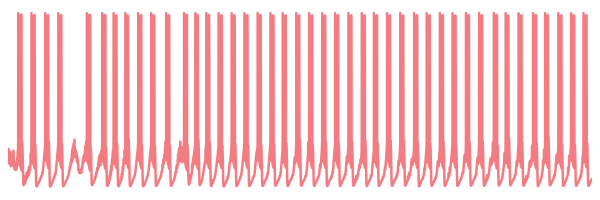

In [23]:
p = plot(tt/1e3, Vconnect[:, 3], xlims=(48, 58), xticks=false, 
         yticks=false, axis=false, linewidth=2.5, legend=false, size=(600, 200), 
         color=mySalmon, margins=0px)

display(p)
# savefig(p, "./figures/network_inner_NMDoff.pdf")

In [11]:
window_size_s = 5
padding_s = 0.2
window_size = Int64(round(window_size_s*1000*length(tt)/Tfinal))
padding = Int64(round(padding_s*1000*length(tt)/Tfinal))
tt_moving_average = window_size_s/2 : padding_s : Tfinal/1000 - window_size_s/2
tt_moving_average_plot = range(0, Tfinal/1e3, length(tt_moving_average))

window_size_s2 = 10
padding_s2 = 0.4
window_size2 = Int64(round(window_size_s2*1000*length(tt)/Tfinal))
padding2 = Int64(round(padding_s2*1000*length(tt)/Tfinal))
tt_moving_average2 = window_size_s2/2 : padding_s2 : Tfinal/1000 - window_size_s2/2
tt_moving_average_plot2 = range(0, Tfinal/1e3, length(tt_moving_average2));

In [12]:
Ca_average_plot1 = moving_average(Caconnect[:, 1], window_size, padding)
Ca_average_plot2 = moving_average(Caconnect[:, 2], window_size, padding)
Ca_average_plot3 = moving_average(Caconnect[:, 3], window_size, padding)
Ca_average_plot4 = moving_average(Caconnect[:, 4], window_size2, padding2)
Ca_average_plot5 = moving_average(Caconnect[:, 5], window_size2, padding2);

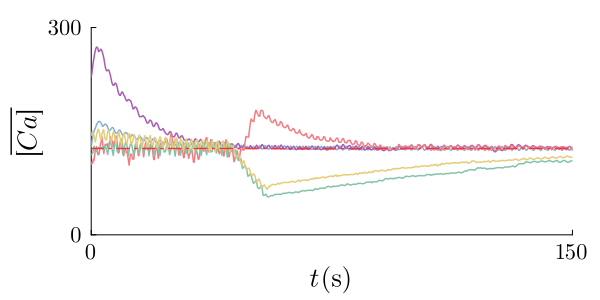

In [13]:
p2b = plot(size=(600, 300), ylims=(0, 300), yticks=([0, 300], [L"0", L"300"]), 
           xlims=(0, 150), guidefontsize=18, xticks=([0, 150], [L"0", L"150"]), tickfontsize=15)

ylabel!(L"\overline{[Ca]}")
xlabel!(L"t\,\mathrm{(s)}")

plot!(tt_moving_average_plot, Ca_average_plot1, linewidth=1.5, color=myBlue, 
      legend=false)
plot!(tt_moving_average_plot, Ca_average_plot2, linewidth=1.5, color=myPurple, 
      legend=false)
plot!(tt_moving_average_plot, Ca_average_plot3, linewidth=1.5, color=mySalmon, 
      legend=false)
plot!(tt_moving_average_plot2, Ca_average_plot4, linewidth=1.5, color=myGreen, 
      legend=false)
plot!(tt_moving_average_plot2, Ca_average_plot5, linewidth=1.5, color=myYellow, 
      legend=false)

plot!([0, 150], [125, 125], color=:firebrick1, linestyle=:dashdot, linewidth=1.5)

display(p2b)
# savefig(p2b, "./figures/Ca_ma.pdf")

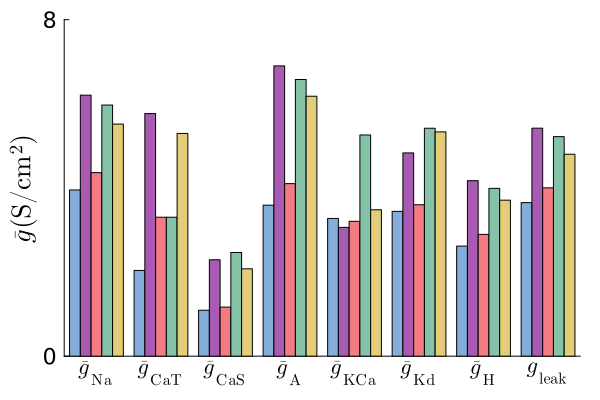

In [14]:
# Defining a matrix containing all conductances
g_all_bar = zeros(ncells, 8)
scaling =  [1, 700, 150, 15, 30, 25, 9000, 400000]
for i = 1 : 8
    g_all_bar[:, i] = g_all_init[:, i] .* scaling[i] / 1e3
end

p4 = bar([1:6:43], g_all_bar[1, :], label="", grid=false, yguidefontsize=18, 
         color=myBlue, ytickfontsize=15, xguidefontsize=15, legendfontsize=12, 
         margin=3Plots.mm, yticks=[0, 8],  xrotation=0, xtickfontsize=15, bar_width=1)

bar!([2:6:44], g_all_bar[2, :], label="", grid=false, yguidefontsize=18, 
         color=myPurple, ytickfontsize=15, xguidefontsize=15, legendfontsize=12, 
         margin=3Plots.mm, yticks=[0, 8],  xrotation=0, xtickfontsize=15, bar_width=1)

bar!([3:6:45], g_all_bar[3, :], label="", grid=false, yguidefontsize=18, 
         color=mySalmon, ytickfontsize=15, xguidefontsize=15, legendfontsize=12, 
         margin=3Plots.mm, yticks=[0, 8],  xrotation=0, xtickfontsize=15, bar_width=1,
         ylabel=L"\bar{g}\,\mathrm{(S/cm^2)}",
         xticks=(3:6:45, [L"\bar{g}_\mathrm{Na}", L"\bar{g}_\mathrm{CaT}", L"\bar{g}_\mathrm{CaS}", 
         L"\bar{g}_\mathrm{A}", L"\bar{g}_\mathrm{KCa}", L"\bar{g}_\mathrm{Kd}", 
         L"\bar{g}_\mathrm{H}", L"g_\mathrm{leak}"]))

bar!([4:6:46], g_all_bar[4, :], label="", grid=false, yguidefontsize=18, 
         color=myGreen, ytickfontsize=15, xguidefontsize=15, legendfontsize=12, 
         margin=3Plots.mm, yticks=[0, 8],  xrotation=0, xtickfontsize=15, bar_width=1)

bar!([5:6:47], g_all_bar[5, :], label="", grid=false, yguidefontsize=18, 
         color=myYellow, ytickfontsize=15, xguidefontsize=15, legendfontsize=12, 
         margin=3Plots.mm, yticks=[0, 8],  xrotation=0, xtickfontsize=15, bar_width=1)

xlims!((0., 48.))
ylims!((0, 8))

display(p4)
# savefig(p4, "./figures/network_gbar.pdf")